In [2]:
import pywt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
def clean_data(data, fs = 52):
    #remove the last column, which is the activity label
    data = data.iloc[:, :-1]

    # Compute time based on the sampling frequency of 52 hz
    sample_numbers = np.arange(len(data))
    time = sample_numbers / fs  # Time in seconds

    # Add or update the 'Time' column
    data['Time'] = time

    # Normalize the data (zero mean, unit variance)
    scaler = StandardScaler()
    data[['X', 'Y', 'Z']] = scaler.fit_transform(data[['X', 'Y', 'Z']])

    return data

In [4]:
def plot_time_series(data, activity):
    """
    Plots the 3 channels of the time series data.

    Parameters:
    data (pandas.DataFrame): The time series data.
    activity (str): The activity name to be used in the title.
    """
    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    # Plot X-axis acceleration
    axes[0].plot(data['Time'], data['X'], color='r', label="X-axis")
    axes[0].set_ylabel("Acceleration (X)")
    axes[0].legend()
    axes[0].grid()

    # Plot Y-axis acceleration
    axes[1].plot(data['Time'], data['Y'], color='g', label="Y-axis")
    axes[1].set_ylabel("Acceleration (Y)")
    axes[1].legend()
    axes[1].grid()

    # Plot Z-axis acceleration
    axes[2].plot(data['Time'], data['Z'], color='b', label="Z-axis")
    axes[2].set_xlabel("Time (s)")
    axes[2].set_ylabel("Acceleration (Z)")
    axes[2].legend()
    axes[2].grid()

    # Title for the whole figure
    plt.suptitle(f"Accelerometer Time Series ({activity})")

    # Show plot
    plt.show()

In [5]:
def plot_cwt_spectrograms(data, wavelet, activity, fs=52):
    """
    Plots the Continuous Wavelet Transform (CWT) spectrograms for the given time series data.

    Parameters:
    data (pandas.DataFrame): The time series data with columns 'Time', 'X', 'Y', and 'Z'.
    wavelet (str): The wavelet to use for CWT (e.g., 'mexh' for Mexican Hat).
    activity (str): The activity name to be used in the title.
    fs (float): The sampling frequency in Hz. Default is 52 Hz.
    """
    # Define scales and frequencies for CWT
    f_min, f_max = 1, 26  # Frequency range of interest
    f_c = 0.25  # Center frequency for Mexican Hat wavelet

    # Convert frequencies to scales
    scales = f_c * fs / np.array([f_max, f_min])
    scales = np.linspace(scales[0], scales[1], num=100)  # 100 scales

    # Perform CWT for each signal
    coeff_x, freq_x = pywt.cwt(data['X'], scales, wavelet, sampling_period=1/fs)
    coeff_y, freq_y = pywt.cwt(data['Y'], scales, wavelet, sampling_period=1/fs)
    coeff_z, freq_z = pywt.cwt(data['Z'], scales, wavelet, sampling_period=1/fs)

    # Plot CWT spectrograms (scalograms)
    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

    # X-axis scalogram
    cax_x = axes[0].imshow(np.abs(coeff_x), aspect='auto', extent=[data['Time'].min(), data['Time'].max(), freq_x.max(), freq_x.min()], cmap='jet')
    axes[0].set_title("CWT Scalogram - X Axis")
    axes[0].set_ylabel("Frequency (Hz)")
    axes[0].grid()
    fig.colorbar(cax_x, ax=axes[0], orientation='vertical', label='Coefficient Magnitude')

    # Y-axis scalogram
    cax_y = axes[1].imshow(np.abs(coeff_y), aspect='auto', extent=[data['Time'].min(), data['Time'].max(), freq_y.max(), freq_y.min()], cmap='jet')
    axes[1].set_title("CWT Scalogram - Y Axis")
    axes[1].set_ylabel("Frequency (Hz)")
    axes[1].grid()
    fig.colorbar(cax_y, ax=axes[1], orientation='vertical', label='Coefficient Magnitude')

    # Z-axis scalogram
    cax_z = axes[2].imshow(np.abs(coeff_z), aspect='auto', extent=[data['Time'].min(), data['Time'].max(), freq_z.max(), freq_z.min()], cmap='jet')
    axes[2].set_title("CWT Scalogram - Z Axis")
    axes[2].set_ylabel("Frequency (Hz)")
    axes[2].set_xlabel("Time (s)")
    axes[2].grid()
    fig.colorbar(cax_z, ax=axes[2], orientation='vertical', label='Coefficient Magnitude')

    # Title for the whole figure
    plt.suptitle(f"CWT Spectrograms ({activity})")

    # Show the figure
    plt.tight_layout()
    plt.show()

In [6]:
# Load the data from the CSV file
column_names = ['Time', 'X', 'Y', 'Z', 'Label']
data = pd.read_csv('./dataset/9.csv', header=None, names=column_names)

# separate the data into 7 different structures, one for each different activity
working_pc = data[data['Label'] == 1]
standing_stairs = data[data['Label'] == 2]
standing = data[data['Label'] == 3]
walking = data[data['Label'] == 4]
stairs = data[data['Label'] == 5]
walking_talking = data[data['Label'] == 6]
standing_talking = data[data['Label'] == 7]

# Clean the data
working_pc = clean_data(working_pc)
standing_stairs = clean_data(standing_stairs)
standing = clean_data(standing)
walking = clean_data(walking)
stairs = clean_data(stairs)
walking_talking = clean_data(walking_talking)
standing_talking = clean_data(standing_talking)


In [7]:
sombrero = pywt.ContinuousWavelet('mexh')
print(sombrero)

ContinuousWavelet mexh
  Family name:    Mexican hat wavelet
  Short name:     mexh
  Symmetry:       symmetric
  DWT:            False
  CWT:            True
  Complex CWT:    False


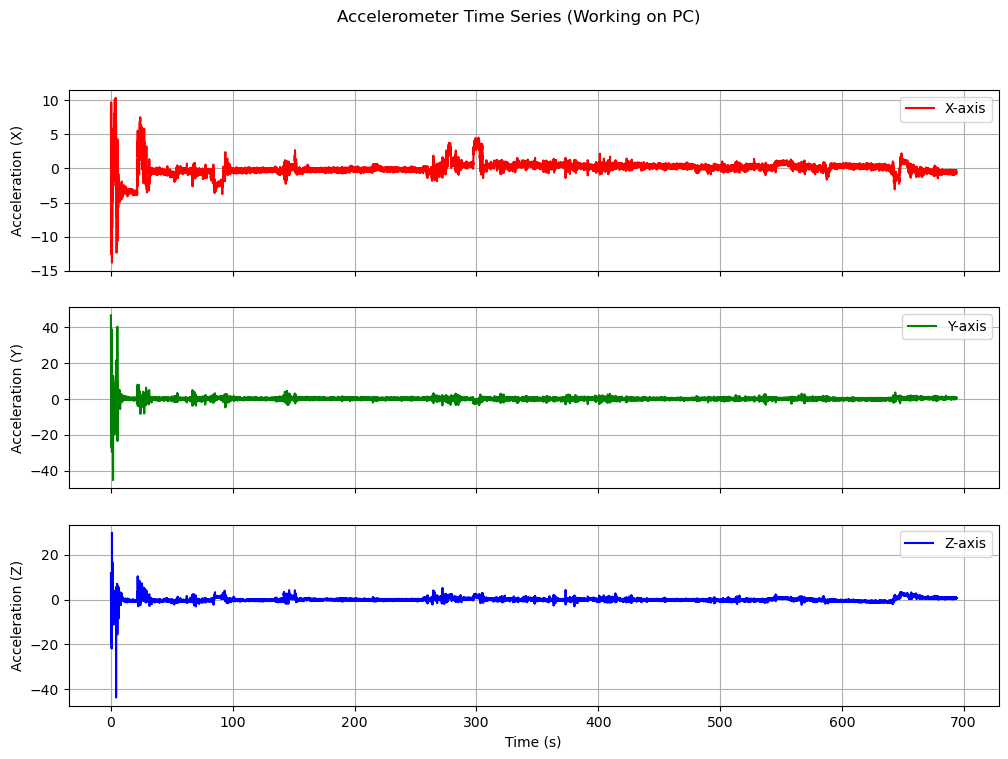

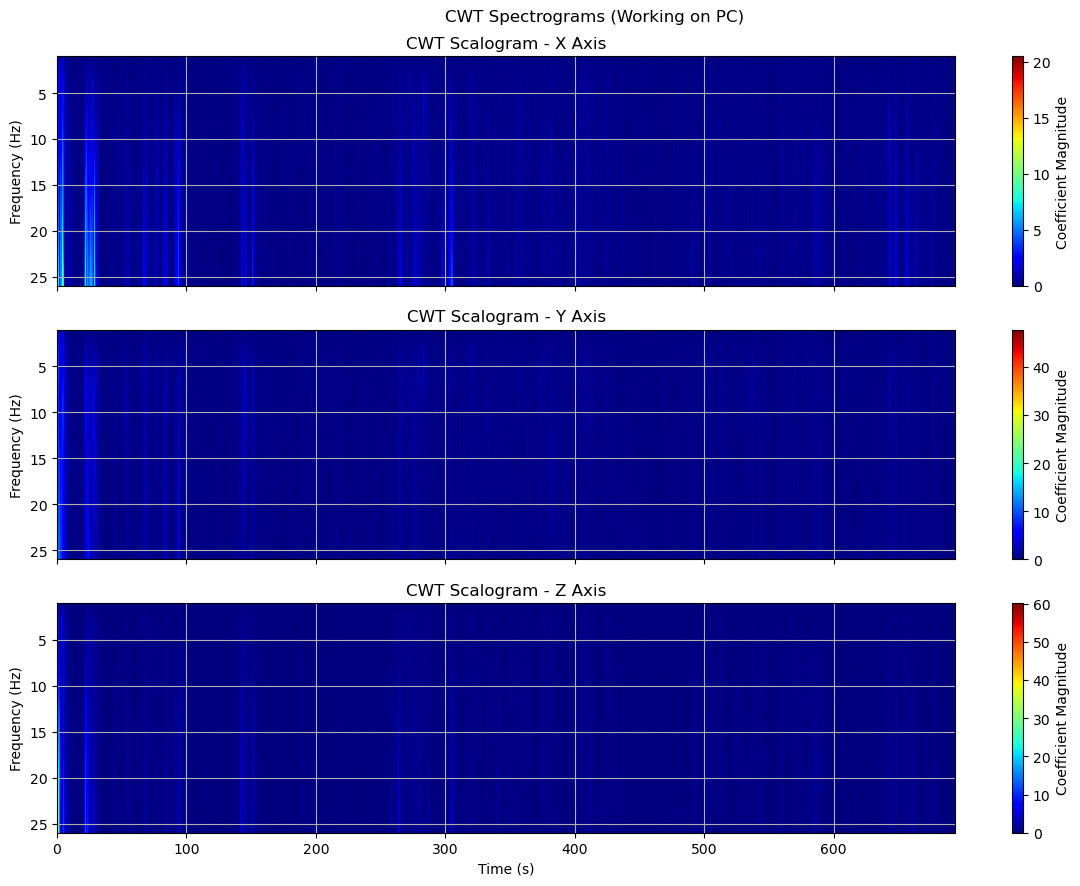

In [8]:
# Plot the time series data for the activity of working_pc
plot_time_series(working_pc, "Working on PC")
# Plot the CWT spectrograms for the activity of working_pc
plot_cwt_spectrograms(working_pc, 'mexh', "Working on PC")

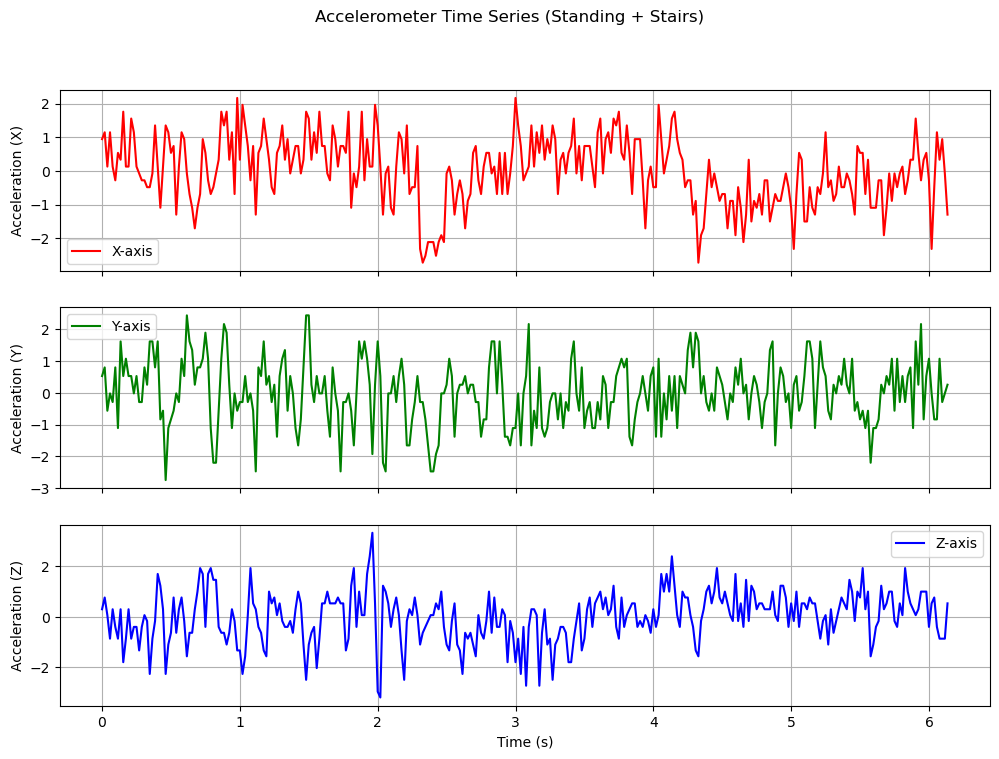

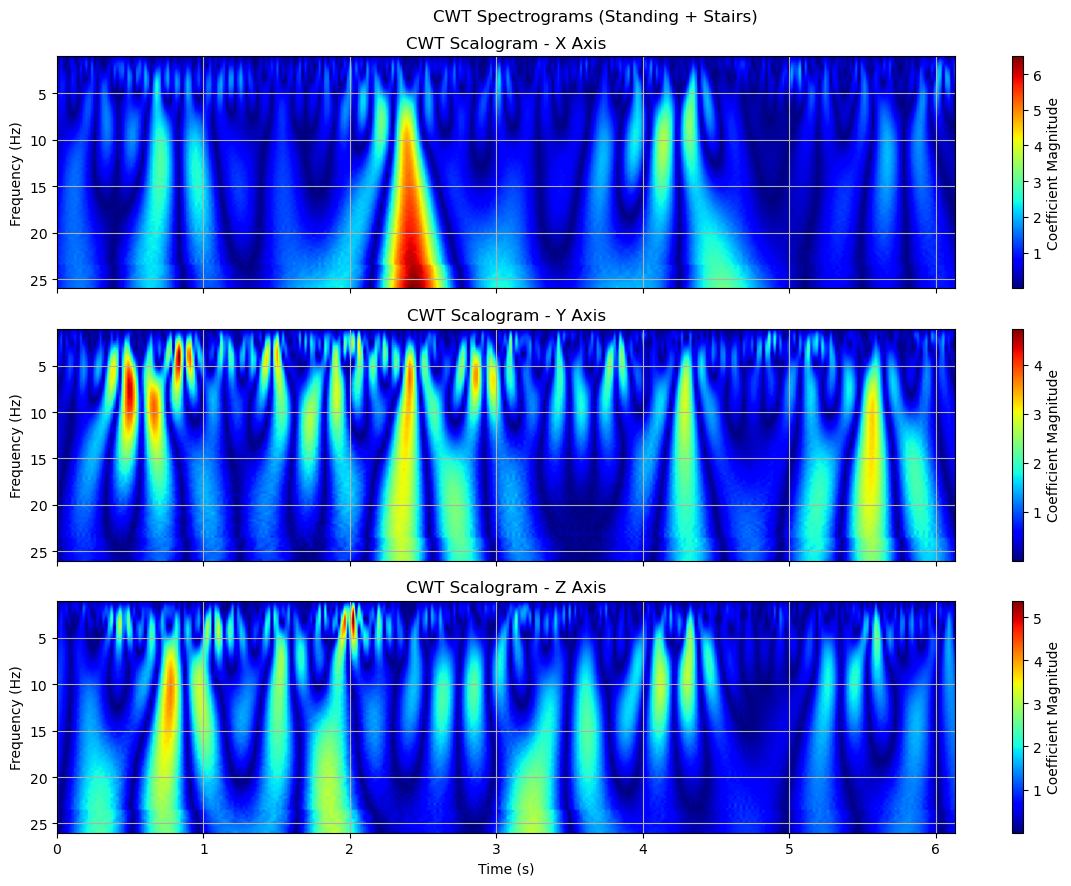

In [9]:
# Plot the time series data for the activity of standing + stairs
plot_time_series(standing_stairs, "Standing + Stairs")
# Plot the CWT spectrograms for the activity of standing + stairs
plot_cwt_spectrograms(standing_stairs, sombrero, "Standing + Stairs")


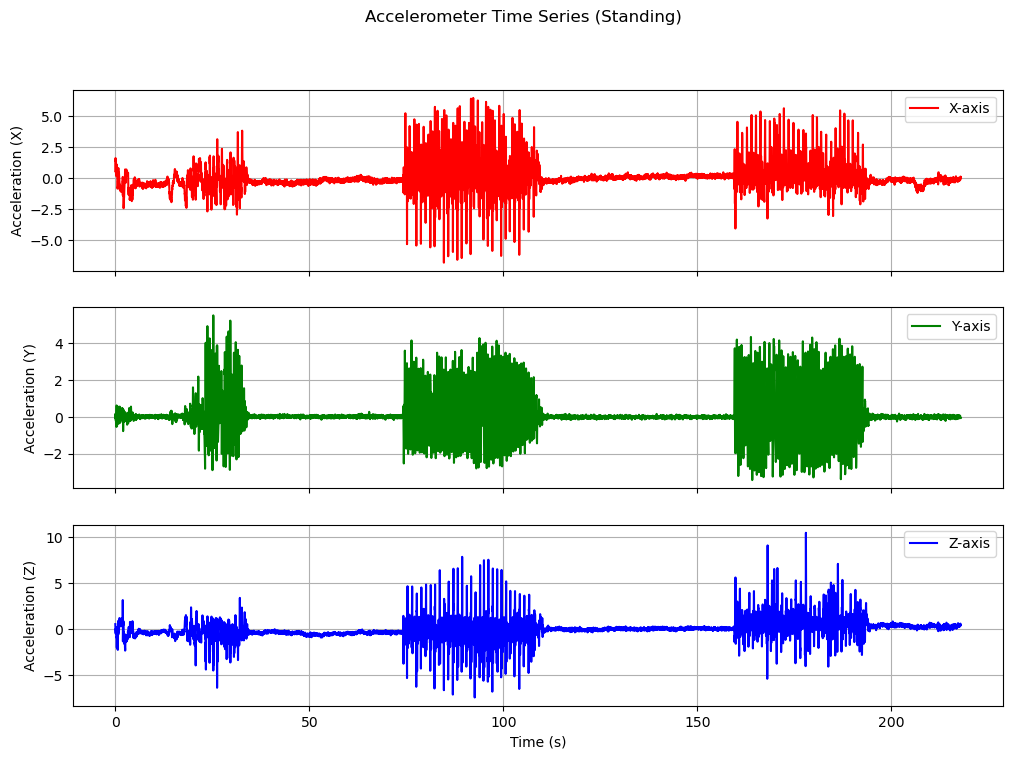

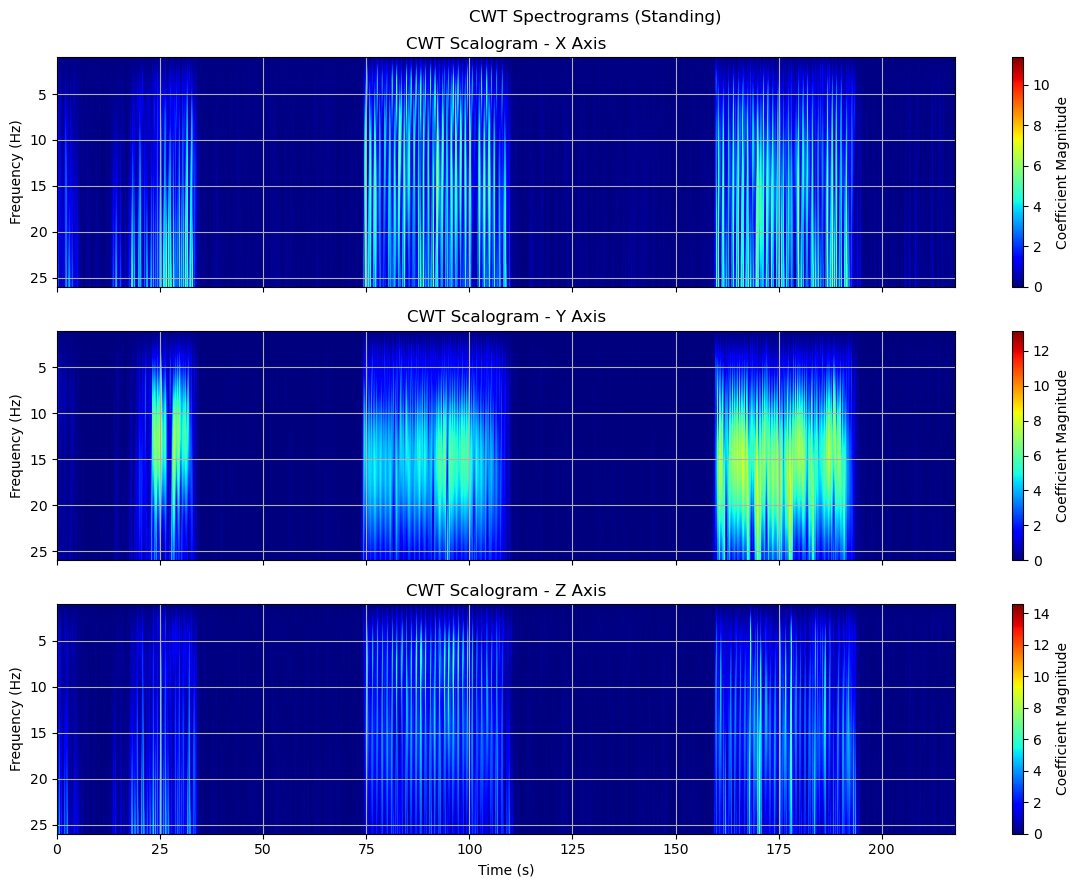

In [10]:
# Plot the time series data for the activity of standing
plot_time_series(standing, "Standing")
# plot the CWT spectrograms for the activity of standing
plot_cwt_spectrograms(standing, sombrero, "Standing")

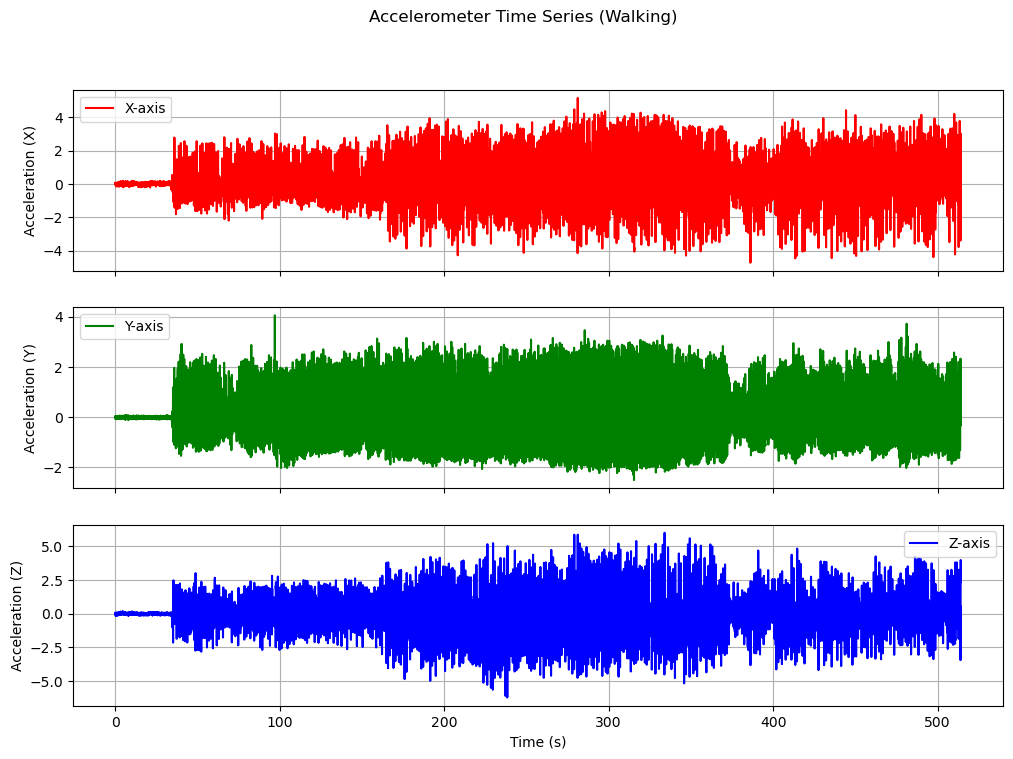

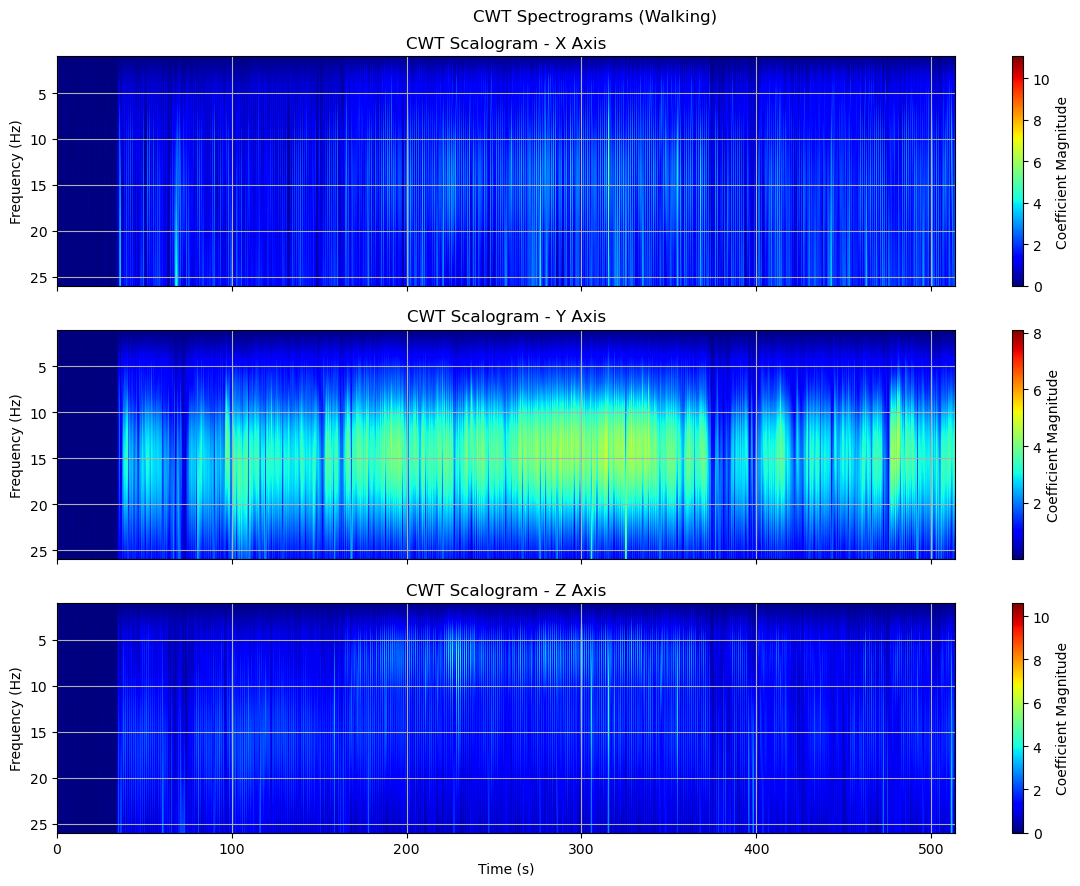

In [11]:
# plot the time series data for the activity of walking
plot_time_series(walking, "Walking")
# plot the CWT spectrograms for the activity of walking
plot_cwt_spectrograms(walking, sombrero, "Walking")


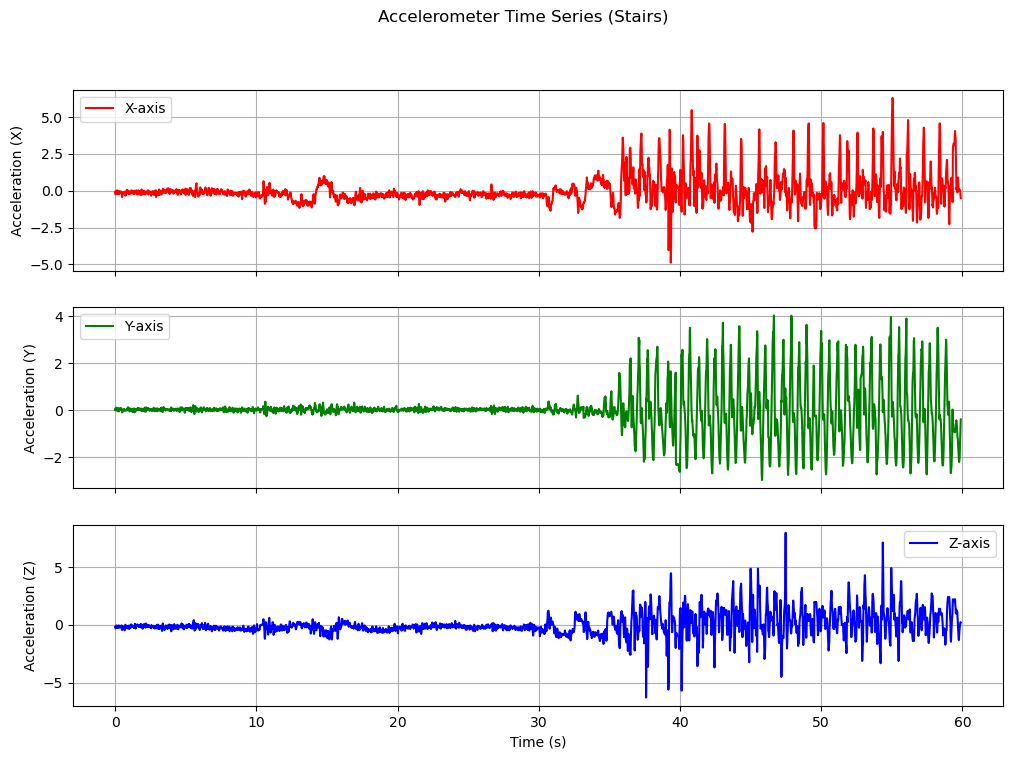

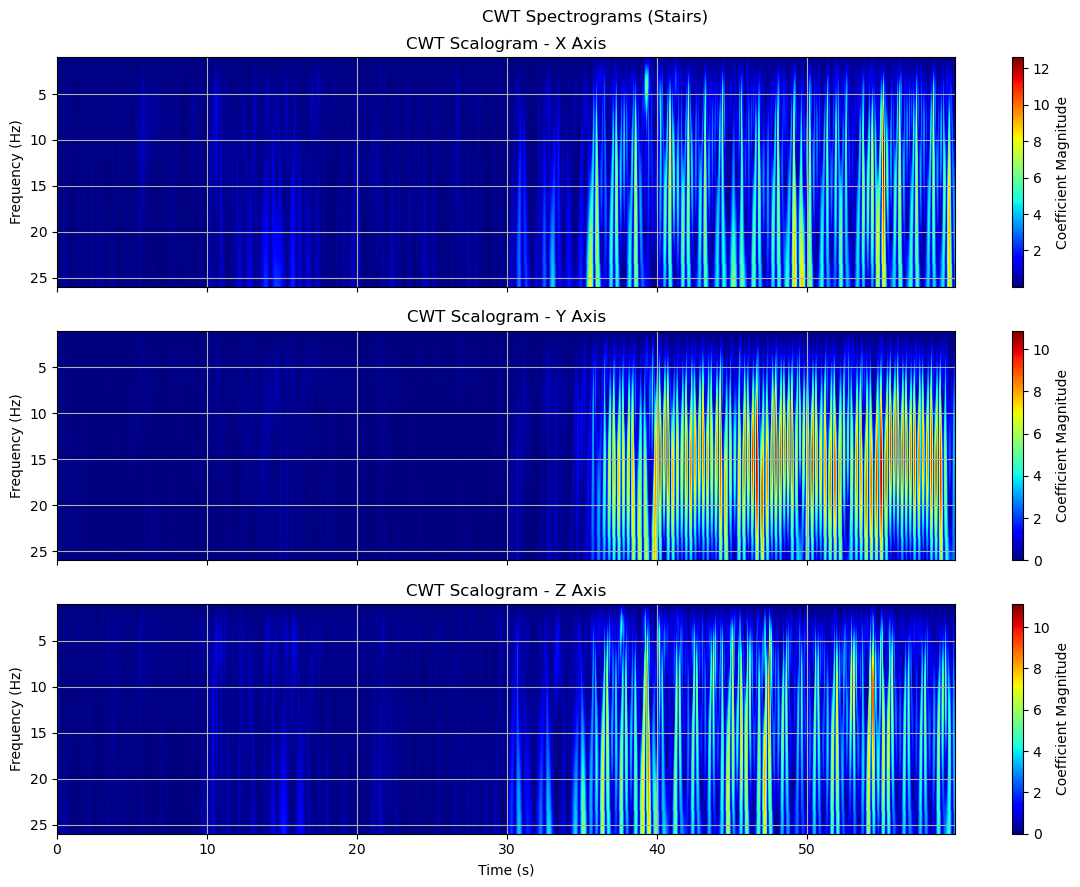

In [12]:
# plot the time series data for the activity of stairs
plot_time_series(stairs, "Stairs")
# plot the CWT spectrograms for the activity of stairs
plot_cwt_spectrograms(stairs, sombrero, "Stairs")

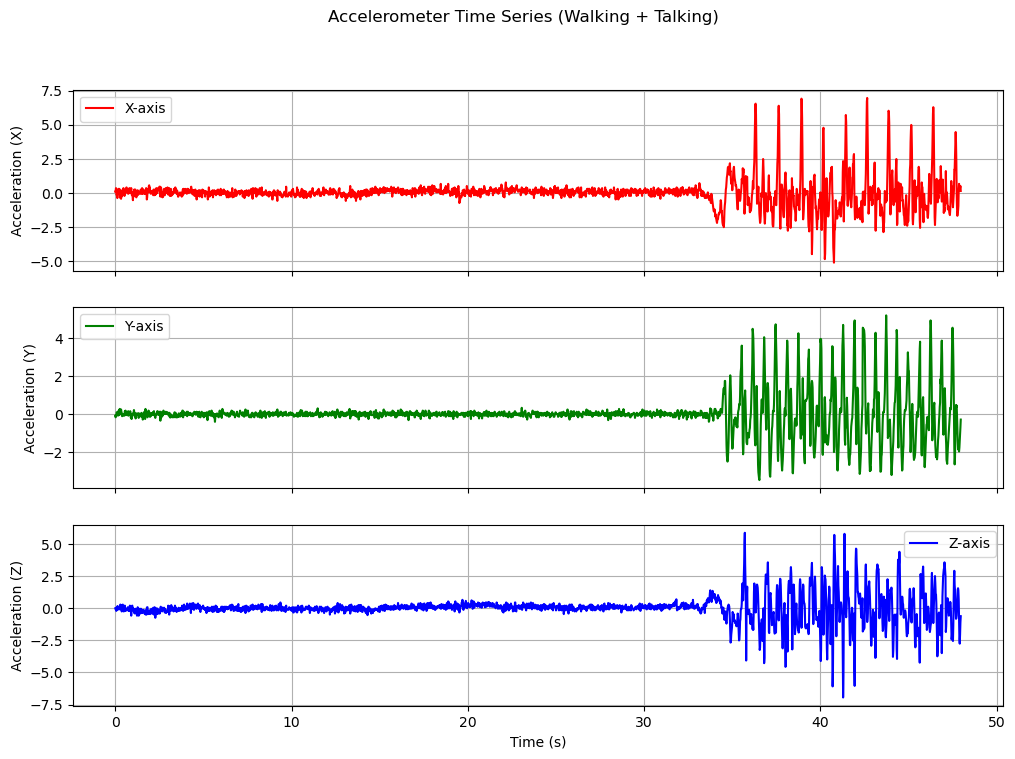

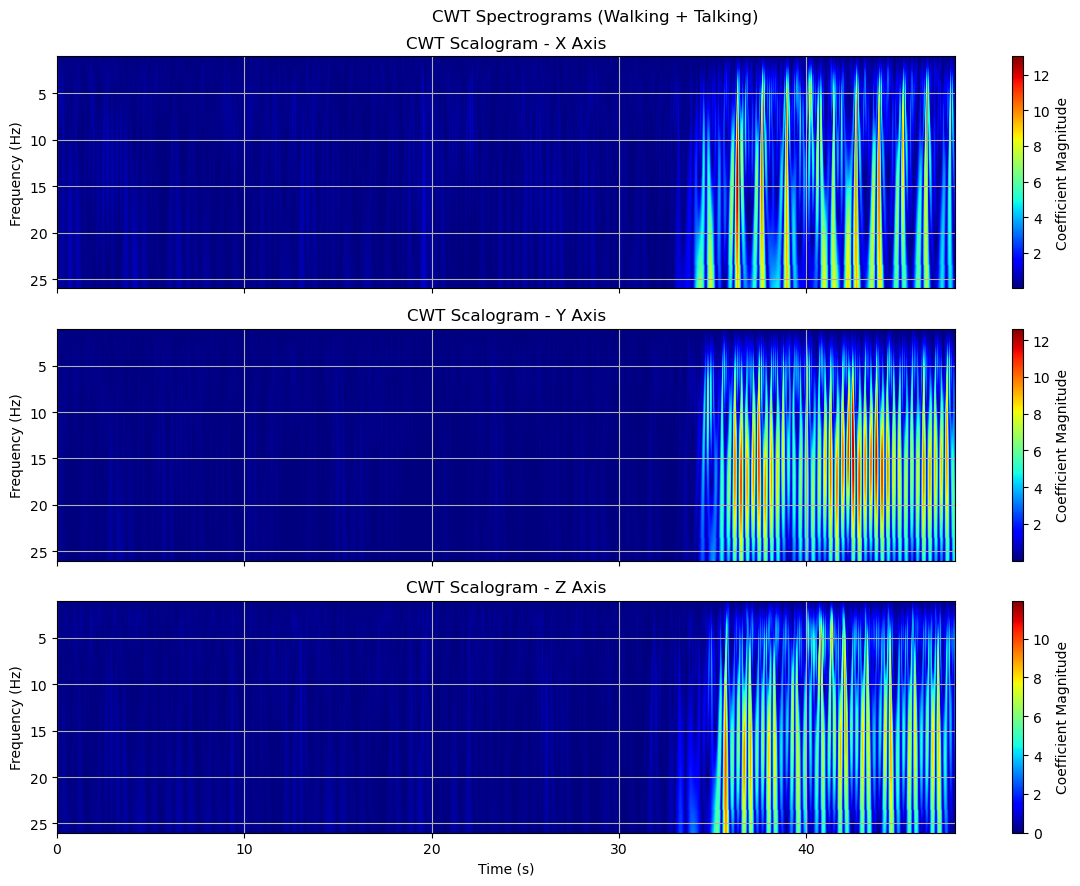

In [13]:
# plot the time series data for the activity of walking + talking
plot_time_series(walking_talking, "Walking + Talking")
# plot the CWT spectrograms for the activity of walking + talking
plot_cwt_spectrograms(walking_talking, sombrero, "Walking + Talking")

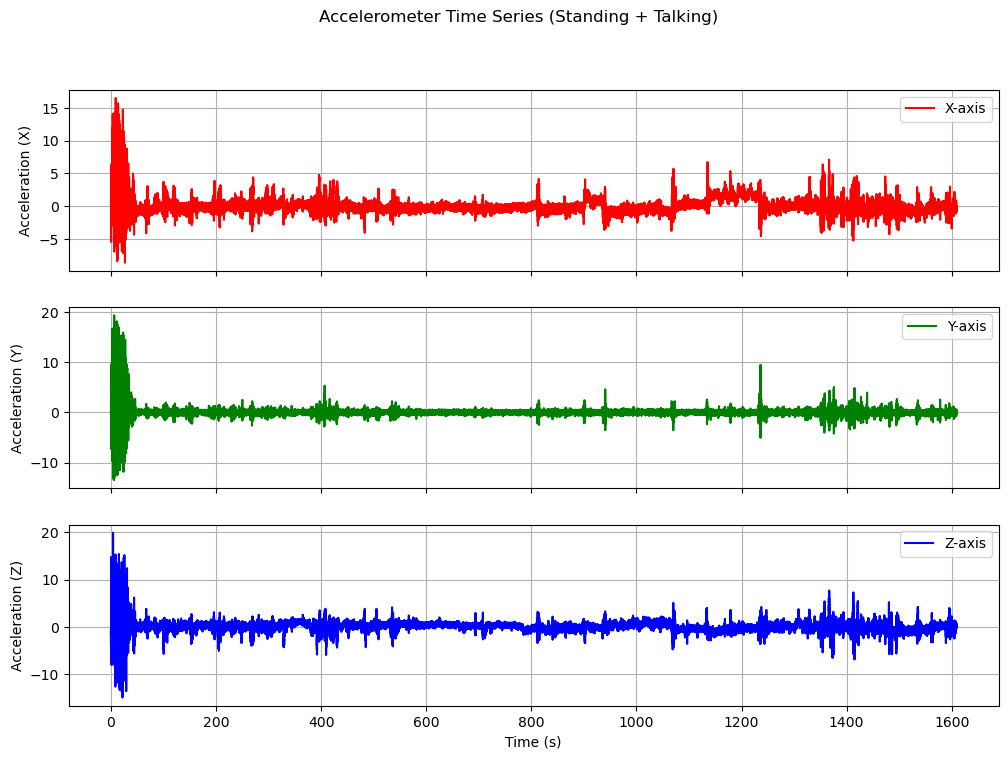

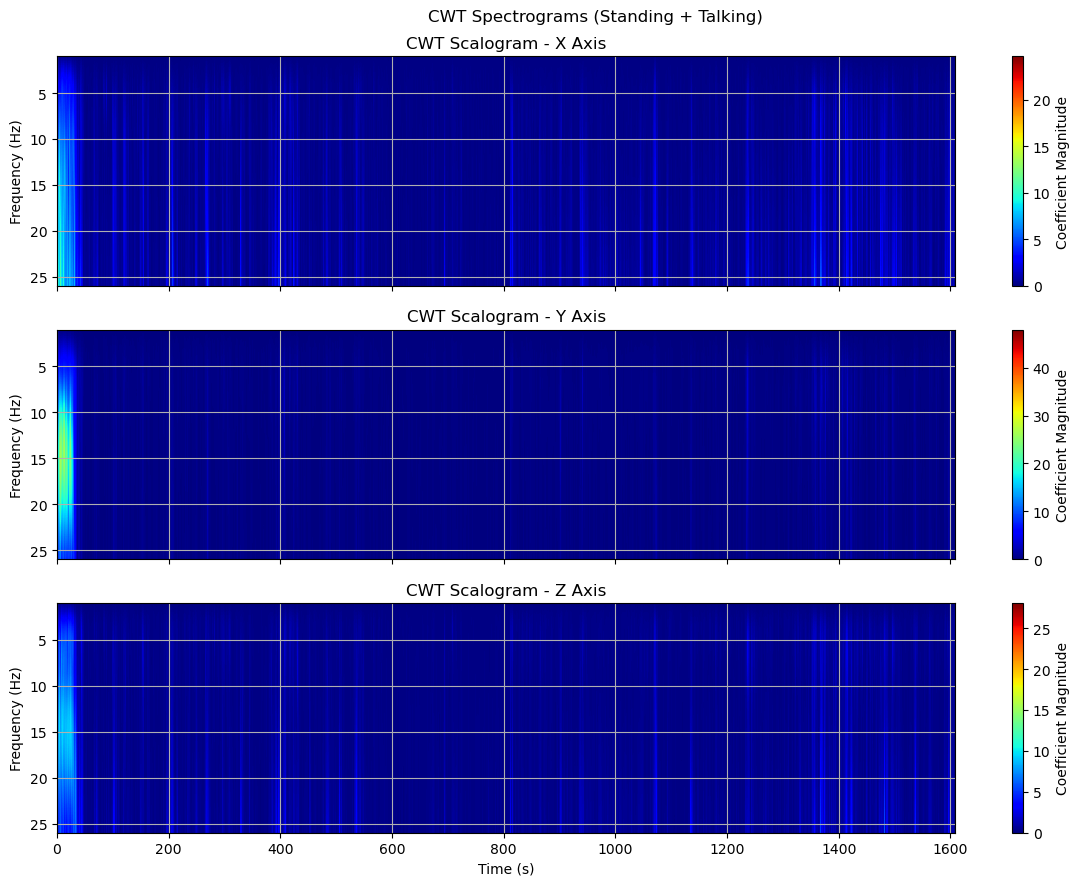

In [14]:
# plot the time series data for the activity of standing + talking
plot_time_series(standing_talking, "Standing + Talking")
# plot the CWT spectrograms for the activity of standing + talking
plot_cwt_spectrograms(standing_talking, sombrero, "Standing + Talking")